In [59]:
import pylab
import sys
import pymzml
import numpy as np
import pickle
import os

In [89]:
path = "~/image_label/data.pkl"
import pickle
with open(os.path.expanduser(path), "rb"):
    _data = pickle.load(open(os.path.expanduser(path), "rb"))
data = _data["data"]
Ys = _data["Ys"]

In [61]:
data.shape

(390, 1200)

In [62]:

import torch.nn as nn
import json
import torch 

with open("../../config.json","r") as f:
    config = json.load(f)
config["BS"] = 1
# config["K"] = 64


In [90]:

class BaseModel(nn.Module):
        def __init__(self, pred):
            super().__init__()
            # self.bert = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased')
            # self.bert = self.bert.encoder
            self.bert = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(config["dim"], config["nhead"], batch_first=True), 
                                                    num_layers=config["N"],
                                                    norm=nn.LayerNorm(config["dim"]),
            )
            if config["embedding"] == "linear":
                self.embeding = torch.nn.Linear(24, config["dim"])
            elif config["embedding"] == "conv1d":
                # self.embeding = torch.nn.Conv1d(24, config["dim"], config["dots"]//24+1, stride=config["dots"]//24+1)
                # gpt
                self.embedding_weights = nn.Parameter(torch.randn(config["dots"]//24, 24, config["dim"]))
                self.embedding_bias = nn.Parameter(torch.randn((config["dots"]//24, config["dim"])))
            else:
                raise NotImplementedError("Only linear and conv1d are supported")
            
            self.proj = nn.Sequential(
                nn.Linear(config["dim"], 2*config["dim"]),
                nn.BatchNorm1d(2*config["dim"]),
                nn.GELU(),
                nn.Linear(2*config["dim"], 4*config["dim"]),
                nn.BatchNorm1d(4*config["dim"]),
                nn.GELU(),
                nn.Linear(4*config["dim"], config["dim"]),
                nn.BatchNorm1d(config["dim"]),
                nn.GELU(),
            )
            
            self.pred = nn.Sequential(
                nn.Linear(config["dim"], 2*config["dim"]),
                nn.BatchNorm1d(2*config["dim"]),
                nn.GELU(),
                nn.Linear(2*config["dim"], 4*config["dim"]),
                nn.BatchNorm1d(4*config["dim"]),
                nn.GELU(),
                nn.Linear(4*config["dim"], config["dim"])
            ) if pred else nn.Identity()
            
            self.head = nn.Linear(config["dim"], config["K"])
            self.pos = torch.nn.Embedding(config["dots"]//24+2, config["dim"])
            self.cls = torch.nn.Parameter(torch.tensor(1.))
            self.norm = nn.BatchNorm1d(config["dim"])
            
        def forward(self, x):
            x = x.reshape(-1, config["dots"]//24, 24)
            mask = x.mean(dim=-1) <= x.mean()/config["snr"]
            if config["embedding"] == "linear":
                x = self.embeding(x)
            elif config["embedding"] == "conv1d":
                x = torch.einsum('bic,ico->bio',x, self.embedding_weights) + self.embedding_bias
            # print(x.shape)
            # x = torch.nn.functional.normalize(x, dim=-1)
            # print("x shape", x.shape, self.cls.repeat(x.shape[0], 1, 1).shape)
            x = torch.cat([torch.zeros(x.shape[0], 1, config["dim"]).to(self.cls.device), x], dim=1)
            pos = self.pos(torch.arange(x.shape[1]).to(self.cls.device).repeat(x.shape[0],1))
            # pos = torch.nn.functional.normalize(self.pos(torch.arange(x.shape[1]).to(self.cls.device).repeat(x.shape[0],1)), dim=-1)
            x = x + pos
            if config["mask_noise"]:
                mask = torch.cat([torch.zeros((x.shape[0], 1)).to(self.cls.device), mask], dim=1).to(torch.bool)
            else:
                mask = torch.zeros((x.shape[0], config["dots"]//24+1)).to(self.cls.device).to(torch.bool)
            assert (x.shape == (x.shape[0], config["dots"]//24+1, config["dim"]))
            x = self.bert(x, src_key_padding_mask=mask)[:,0,:]
            x = self.norm(x)
            return self.head(self.pred(self.proj(x)))             

In [91]:
import sys
sys.path.append("../../")



import moco.builder
model = moco.builder.MoCo(
    BaseModel,
    config["K"],
    65536,
    0.99,
    0.08, 
    True,
)
model = model.train(True)
model = torch.nn.DataParallel(model)
# mod = torch.load("1.pth.tar")
mod = torch.load("../../checkpoint_0005.pth.tar")
# mod = torch.load("checkpoint_0020.pth.tar")
model.load_state_dict(mod["state_dict"]) 

model = model.module.encoder_q
model.pred = nn.Identity() # this?

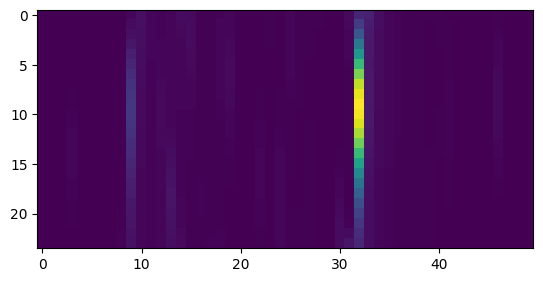

In [119]:
data.shape
pylab.imshow(data[np.where(y==1)[0][1]].reshape(50,24).T)

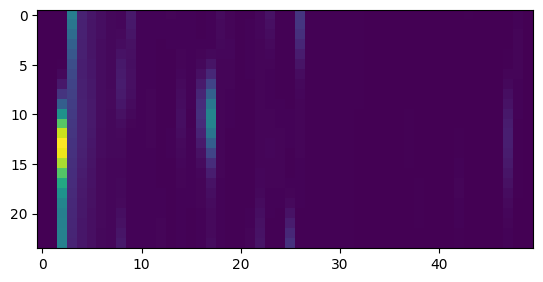

In [122]:
pylab.imshow(data[np.where(y==0)[0][3]].reshape(50,24).T)


In [65]:
data.shape

(390, 1200)

In [92]:
new_Ys = []
for i in Ys:
    if i == 'winter':
        new_Ys.append(0)
    elif i == "summer":
        new_Ys.append(1)

135826.05102921827

In [93]:
# data = torch.tensor(data).float()
# data = (data/torch.max(data))
data.mean()


135826.05102921827

In [94]:
x = []
y = []
model = model.eval().cuda()
for i in range(len(data)):
    # inter x to 2400
    f = np.interp(np.linspace(0, 1, config["dots"]), np.linspace(0, 1, data.shape[1]), data[i])
    x.append(model(torch.tensor(f).float().unsqueeze(0).cuda()).detach().cpu().numpy())
    y.append(Ys[i])
x = np.array(x)
x = x.squeeze(1)

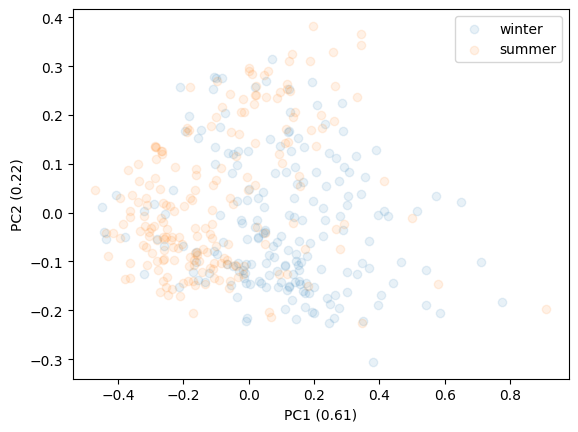

In [95]:
# show PCA of the embeding and color by POS or NEG
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
# x = norm_x #oh because of this, it already read norm x not regualr x
x = np.array(x)
y = np.array(y)
try:
    x = x.squeeze(1)
except:
    pass
x2 = pca.fit_transform(x)
# pylab.scatter(x2[y=="winter",0], x2[y=="winter",1], label="winter")
# pylab.scatter(x2[y=="summer",0], x2[y=="summer",1], label="summer")
# pylab.scatter(x2[y=="standard",0], x2[y=="standard",1], label="standard")
# same thing but label is "Dairy Land" and "Island Farm"
pylab.scatter(x2[y=="winter",0], x2[y=="winter",1], label="winter", alpha=0.1)
pylab.scatter(x2[y=="summer",0], x2[y=="summer",1], label="summer", alpha=0.1)
var1 = pca.explained_variance_ratio_[0]
var2 = pca.explained_variance_ratio_[1]
pylab.xlabel(f"PC1 ({var1:.2f})")
pylab.ylabel(f"PC2 ({var2:.2f})")
pylab.legend()


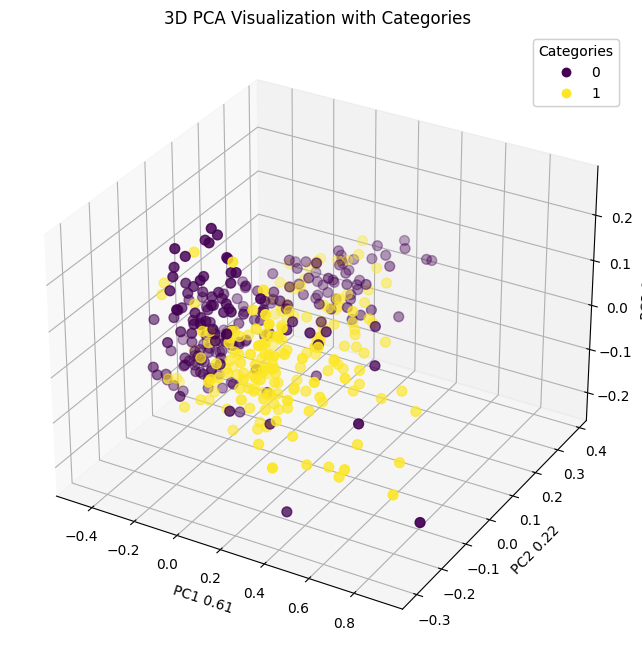

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


# Perform PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(x)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Create a categorical variable for color coding
colors = [0 if i == "summer" else 1 for i in y]

# Visualize in 3D

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=colors, cmap='viridis', s=50, depthshade=True)

# Add labels
ax.set_title("3D PCA Visualization with Categories")
var1 = pca.explained_variance_ratio_[0]
var2 = pca.explained_variance_ratio_[1]
var3 = pca.explained_variance_ratio_[2]

ax.set_xlabel(f"PC1 {var1:.2f}")
ax.set_ylabel(f"PC2 {var2:.2f}")
ax.set_zlabel(f"PC3 {var3:.2f}")

# Add legend
legend1 = ax.legend(*scatter.legend_elements(), title="Categories")
ax.add_artist(legend1)

plt.show()


In [17]:
del model

In [97]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
# F1

y = [1 if i=="winter" else 0 for i in Ys]
n = len(x)
x = np.array(x)
y = np.array(y)
ans = []


svm_sum = 0
lr_rum= 0
knn_sum = 0
n_splits = 10
for train_index, test_index in KFold(n_splits=n_splits, shuffle=True).split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf1 = SVC(max_iter=1000).fit(x_train, y_train) 
    clf2 = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    clf3 = KNeighborsClassifier(n_neighbors=4).fit(x_train, y_train)
    y_pred = clf1.predict(x_test)
    svm=(f1_score(y_test, y_pred))
    
    y_pred = clf2.predict(x_test)
    lr=(f1_score(y_test, y_pred))
    
    y_pred = clf3.predict(x_test)
    kn=(f1_score(y_test, y_pred))
    print(svm, lr, kn)
    svm_sum += svm
    lr_rum += lr
    knn_sum += kn
print()
print(svm_sum/n_splits, lr_rum/n_splits, knn_sum/n_splits)

0.8095238095238095 0.8636363636363636 0.8372093023255813
0.7200000000000001 0.7200000000000001 0.8
0.6666666666666667 0.65 0.6842105263157896
0.7999999999999999 0.8571428571428571 0.823529411764706
0.75 0.8000000000000002 0.8292682926829269
0.7894736842105262 0.8205128205128205 0.7692307692307692
0.6153846153846153 0.6153846153846153 0.7857142857142857
0.75 0.75 0.8571428571428571
0.7058823529411765 0.7777777777777778 0.9
0.6976744186046512 0.7111111111111111 0.7142857142857143

0.7304605547331445 0.7565565545565546 0.800059115946263


In [20]:
# finetune
x_train = torch.tensor(data[:-80])
y_train = torch.tensor(new_Ys[:-80])
x_val = torch.tensor(data[-80:])
y_val = torch.tensor(new_Ys[-80:])

In [21]:
class Classfier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = model
        self.fc = nn.Linear(config["K"], 1)
    def forward(self, x):
        return torch.nn.functional.sigmoid(self.fc(self.backbone(x)))

In [25]:
classfier = Classfier().cuda()
optimizer = torch.optim.AdamW(classfier.parameters(), lr=1e-4)
train_data = data[:int(len(data)*0.8)]
train_Ys = new_Ys[:int(len(data)*0.8)]
val_data = torch.tensor(data[int(len(data)*0.8):])
val_Ys = torch.tensor(new_Ys[int(len(data)*0.8):])
# import wandb
# wandb.init()

for i in range(0,train_data.shape[0],36):
    X = torch.tensor(train_data[i:min(i+36, train_data.shape[0])]).cuda()
    Y = torch.tensor(train_Ys[i:min(i+36, train_data.shape[0])]).cuda()
    optimizer.zero_grad()
    output = classfier(X.float())
    acc = (output.round() == Y.float().unsqueeze(1)).float().mean()
    loss = torch.nn.functional.binary_cross_entropy(output, Y.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    val_loss = torch.nn.functional.binary_cross_entropy(classfier(val_data.float().cuda()), torch.tensor(val_Ys).float().cuda().unsqueeze(1))
    val_acc = (classfier(val_data.float().cuda()).round() == torch.tensor(val_Ys).float().cuda().unsqueeze(1)).float().mean()
    wandb.log({"loss": loss.item(), "acc": acc.item(), "val_loss": val_loss.item(), "val_acc": val_acc.item()})

/home/wg25r/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
